In [1]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.stats import spearmanr
from scipy.stats import stats

import seaborn as sns
import matplotlib.colors as mcolors

In [2]:
bdata_bin100 = sc.read_h5ad("gRNA/B926/D03658A6.tissue.guide.h5")

In [3]:
mask = bdata_bin100.var_names.str.startswith("sg")
fdata = bdata_bin100[:, ~mask].copy()
cdata = bdata_bin100[:, mask].copy()

In [4]:
sgs = cdata.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(cdata.X.toarray(), columns=cdata.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=cdata.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = cdata.obsm['spatial']
cdata = sgdata.copy()

/tmp/ipykernel_28433/1049114494.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [5]:
fdata_1 = fdata.copy()
cdata_1 = cdata.copy()

In [6]:
fdata_bin20 = ad.read_h5ad("./RNA/B926-1.expr.bin_20.annotation.h5")
cdata_bin20 = ad.read_h5ad("./RNA/B926-1.guide.bin_20.h5")

In [7]:
mask = fdata_bin20.var_names.str.startswith("sg")
fdata_bin20 = fdata_bin20[:, ~mask].copy()

In [8]:
sgs = cdata_bin20.var_names.str.split('_', n=1).str[0]
sgs_grouped = pd.DataFrame(cdata_bin20.X.toarray(), columns=cdata_bin20.var_names)
sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()
sgdata = ad.AnnData(sgs_grouped, obs=cdata_bin20.obs, var=pd.DataFrame(index=sgs_grouped.columns))
sgdata.obsm['spatial'] = cdata_bin20.obsm['spatial']
cdata_bin20 = sgdata.copy()

/tmp/ipykernel_28433/2956383191.py:3: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  sgs_grouped = sgs_grouped.groupby(sgs, axis=1).sum()


In [9]:
sq.gr.spatial_neighbors(cdata_1, spatial_key="spatial")

In [10]:
guide="sgGata3"
threshold = np.quantile(cdata_1.X, 0.999)
mask = cdata_1[:, guide].X > threshold

In [11]:
def extract_bin20(bin20_data, bin100_masked_data, replace_obs=None, offset=0):
    s_data = bin20_data.copy()
    s_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100 + offset) * 100]) for array in s_data.obsm["spatial"]]
    b_data = bin100_masked_data.copy()
    b_data.obs["spatial_cov"] = [tuple([(array[0] // 100) * 100, (array[1] // 100 + offset) * 100]) for array in b_data.obsm["spatial"]]
    
    mask = [array in b_data.obs["spatial_cov"].tolist() for array in s_data.obs["spatial_cov"]]

    if replace_obs:
        for obj in replace_obs:
            spatial_to_obs = dict(zip(b_data.obs["spatial_cov"], b_data.obs[obj]))
            s_data.obs[obj] = s_data.obs["spatial_cov"].map(spatial_to_obs)
    return s_data[mask].copy()

def find_near(bin100, bin100_data, border=1, bin_size=100):
    cmin = ((bin100.obsm["spatial"] // bin_size - border) * bin_size)[0]
    cmax = ((bin100.obsm["spatial"] // bin_size + border + 1) * bin_size)[0]
    mask = [cmin[0] <= array[0] <= cmax[0] and cmin[1] <= array[1] <= cmax[1] for array in bin100_data.obsm["spatial"]]
    return bin100_data[mask]

In [156]:
extract_bin20(fdata_bin20, find_near(fdata_1[mask][10], fdata_1, border=2))[:, "Pdcd1"].X.toarray()

array([[0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [2.85147  ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [3.1303434],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],
       [0.       ],


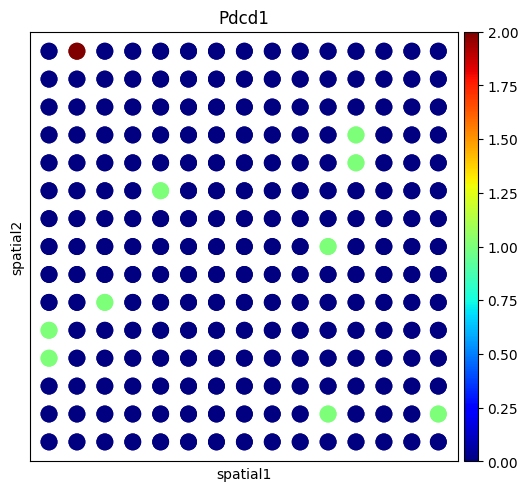

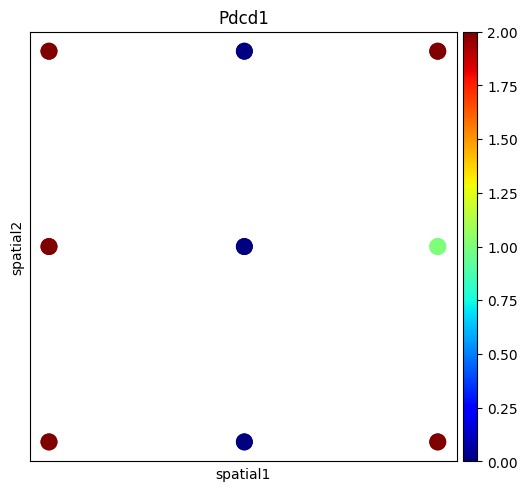

In [13]:
sq.pl.spatial_scatter(extract_bin20(fdata_bin20, find_near(cdata_1[mask][10], fdata_1, border=1)), layer="counts", color="Pdcd1", shape=None, size=500, library_id="spatial", cmap='jet')
sq.pl.spatial_scatter(find_near(cdata_1[mask][10], fdata_1, border=1), color="Pdcd1", shape=None, size=500, library_id="spatial", cmap='jet')
plt.show()

In [107]:
cdata_filt = extract_bin20(cdata_bin20, cdata_1[mask], offset=0)
cdata_filt[:, "sgGata3"].X.sum()

array(6435)

In [105]:
cdata_1[mask][:, "sgGata3"].X.sum()

array(6435)

In [71]:
np.sum(mask)

119

In [75]:
cdata_filt

AnnData object with n_obs × n_vars = 0 × 34
    obs: 'spatial_cov'
    obsm: 'spatial'

# 背景：随机选择

In [171]:
near_mask = cdata_1.obsp["spatial_distances"][mask.T[0]].toarray().sum(axis=0) > 0
near_mask = near_mask.flatten() | mask.flatten()

random_mask = np.zeros(len(mask), dtype=bool)
random_mask[np.random.choice(fdata_1.n_obs, size=np.sum(mask), replace=False)] = True

random_near_mask = fdata_1.obsp["spatial_distances"][random_mask].toarray().sum(axis=0) > 0
random_near_mask = random_near_mask.flatten() | random_mask

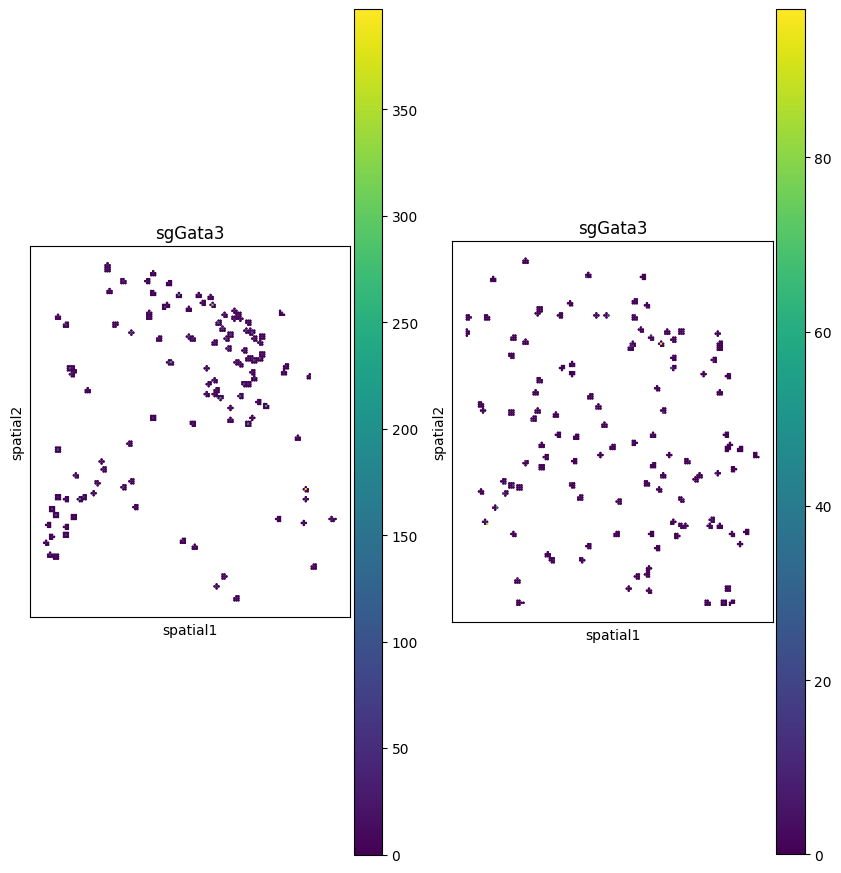

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))
sq.pl.spatial_scatter(cdata_1[near_mask], color="sgGata3", shape=None, size=2, library_id="spatial", ax=ax[0])
sq.pl.spatial_scatter(cdata_1[random_near_mask], color="sgGata3", shape=None, size=2, library_id="spatial", ax=ax[1])

In [104]:
fdata_1.obs["cluster"] = 0
fdata_1.obs["cluster"][random_near_mask] = "random"
fdata_1.obs["cluster"][near_mask] = "near"
fdata_filt = fdata_1[random_near_mask | near_mask].copy()

/tmp/ipykernel_63480/3656351191.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  fdata_1.obs["cluster"][random_near_mask] = "random"
/tmp/ipykernel_63480/3656351191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [115]:
sc.tl.rank_genes_groups(fdata_filt, groupby="cluster", method="t-test_overestim_var")

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for

<Figure size 2000x2000 with 0 Axes>

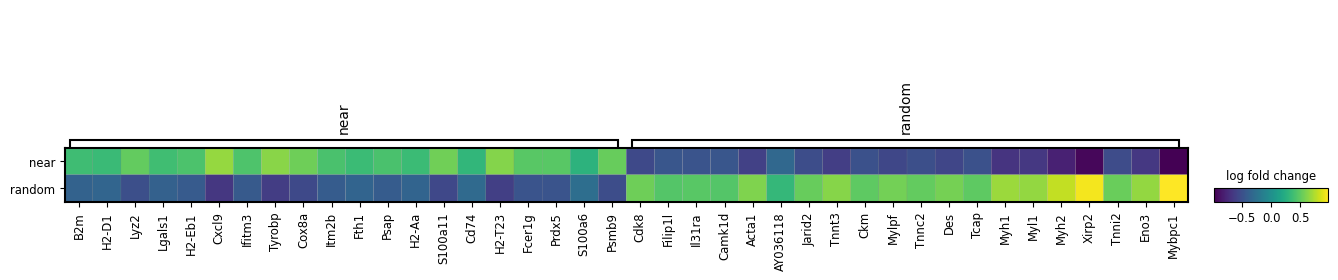

In [124]:
plt.figure(figsize=(20, 20))
sc.pl.rank_genes_groups_matrixplot(fdata_filt, n_genes=20, values_to_plot="logfoldchanges")

# 背景：NTC

In [40]:
guide="sgGata3"
mask = cdata_1[:, guide].X > threshold
near_mask = fdata_1.obsp["spatial_distances"][mask.T[0]].toarray().sum(axis=0) > 0
near_mask = near_mask.flatten() | mask.flatten()

guide="sgnon-targeting"
random_mask = cdata_1[:, guide].X > threshold
random_near_mask = fdata_1.obsp["spatial_distances"][random_mask.T[0]].toarray().sum(axis=0) > 0
random_near_mask = random_near_mask.flatten() | random_mask.flatten()

mask = mask.flatten()
random_mask = random_mask.flatten()

KeyError: 'spatial_distances'

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


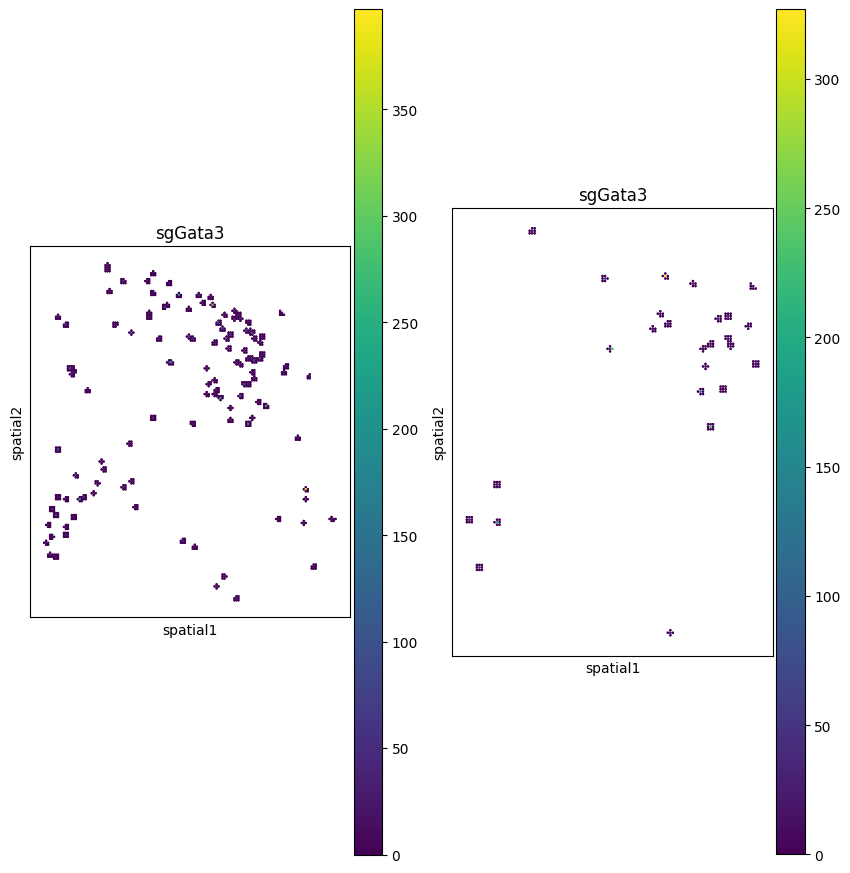

In [130]:
fig, ax = plt.subplots(1, 2, figsize=(10, 20))
sq.pl.spatial_scatter(cdata_1[near_mask], color="sgGata3", shape=None, size=2, library_id="spatial", ax=ax[0])
sq.pl.spatial_scatter(cdata_1[random_near_mask], color="sgGata3", shape=None, size=2, library_id="spatial", ax=ax[1])

In [170]:
fdata_1.obs["cluster"] = 0
fdata_1.obs["cluster"][random_mask] = "random"
fdata_1.obs["cluster"][mask] = "near"
fdata_filt = fdata_1[mask | random_mask].copy()

/tmp/ipykernel_63480/2213328235.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  fdata_1.obs["cluster"][random_mask] = "random"
/tmp/ipykernel_63480/2213328235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for

<Figure size 2000x2000 with 0 Axes>

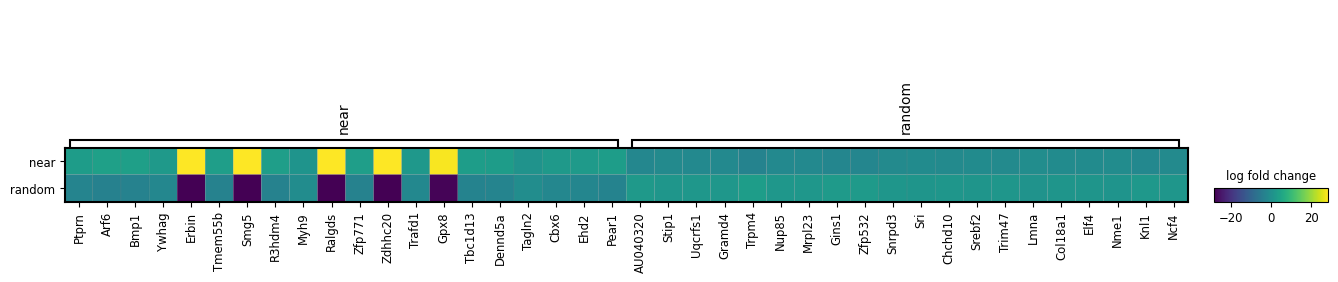

In [171]:
sc.tl.rank_genes_groups(fdata_filt, groupby="cluster", method="t-test_overestim_var")
plt.figure(figsize=(20, 20))
sc.pl.rank_genes_groups_matrixplot(fdata_filt, n_genes=20, values_to_plot="logfoldchanges")

In [172]:
fdata_filt.var_names[fdata_filt.var_names.str.startswith("Pdcd1")]

Index(['Pdcd1', 'Pdcd11', 'Pdcd1lg2'], dtype='object')

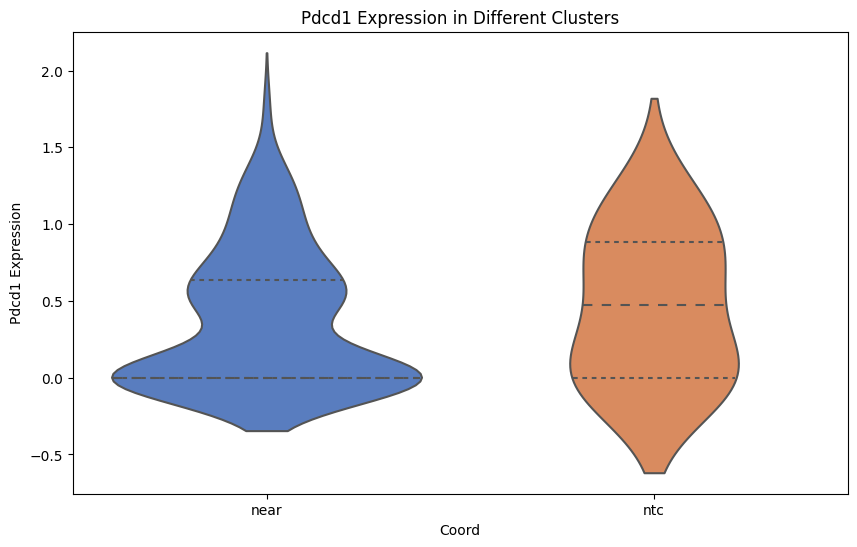

In [174]:
a = fdata_filt[fdata_filt.obs["cluster"] == "near", "Pdcd1"].X.toarray().flatten()
b = fdata_filt[fdata_filt.obs["cluster"] == "random", "Pdcd1"].X.toarray().flatten()

plot_df = pd.DataFrame({
    "Pdcd1": a.tolist() + b.tolist(),
    "coord": ["near"] * len(a) + ["ntc"] * len(b)
})

plt.figure(figsize=(10, 6))
sns.violinplot(x='coord', y='Pdcd1', data=plot_df, inner='quartile', palette='muted')
plt.xlabel('Coord')
plt.ylabel('Pdcd1 Expression')
plt.title('Pdcd1 Expression in Different Clusters')
plt.show()

# 背景： bin20

In [156]:
guide="sgGata3"
mask = cdata_1[:, guide].X > threshold
near_mask = fdata_1.obsp["spatial_distances"][mask].toarray().sum(axis=0) > 0
near_mask = near_mask.flatten() | mask.flatten()

random_mask = np.zeros(len(mask), dtype=bool)
random_mask[np.random.choice(fdata_1.n_obs, size=np.sum(mask), replace=False)] = True

random_near_mask = fdata_1.obsp["spatial_distances"][random_mask].toarray().sum(axis=0) > 0
random_near_mask = random_near_mask.flatten() | random_mask

KeyError: 'spatial_distances'

In [276]:
guide="sgGata3"
mask = cdata_1[:, guide].X > threshold
near_mask = fdata_1.obsp["spatial_distances"][mask.T[0]].toarray().sum(axis=0) > 0
near_mask = near_mask.flatten() | mask.flatten()

guide="sgnon-targeting"
random_mask = cdata_1[:, guide].X > threshold
random_near_mask = fdata_1.obsp["spatial_distances"][random_mask.T[0]].toarray().sum(axis=0) > 0
random_near_mask = random_near_mask.flatten() | random_mask.flatten()

mask = mask.flatten()
random_mask = random_mask.flatten()

In [277]:
fdata_1.obs["cluster"] = 0
fdata_1.obs["cluster"][random_mask] = "random"
fdata_1.obs["cluster"][mask] = "near"
fdata_filt = fdata_1[mask | random_mask].copy()

/tmp/ipykernel_63480/2213328235.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  fdata_1.obs["cluster"][random_mask] = "random"
/tmp/ipykernel_63480/2213328235.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

In [258]:
fdata_1.obs["cluster"] = 0
fdata_1.obs["cluster"][random_near_mask] = "random"
fdata_1.obs["cluster"][near_mask] = "near"
fdata_filt = fdata_1[near_mask | random_near_mask].copy()

/tmp/ipykernel_63480/1470213609.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  fdata_1.obs["cluster"][random_near_mask] = "random"
/tmp/ipykernel_63480/1470213609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [279]:
fdata_filt_bin20 = extract_bin20(fdata_bin20, fdata_filt, replace_obs=["cluster"])

In [278]:
fdata_filt.obs.cluster.value_counts()

cluster
near      118
random      9
Name: count, dtype: int64

In [280]:
fdata_filt_bin20.obs.cluster.value_counts()

cluster
near      2903
random     225
Name: count, dtype: int64

In [281]:
fdata_filt_bin20

AnnData object with n_obs × n_vars = 3128 × 27798
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt1', 'pct_counts_mt1', 'total_counts_mt2', 'pct_counts_mt2', 'total_counts_rb', 'pct_counts_rb', 'annotations', 'spatial_cov', 'cluster'
    var: 'mt1', 'mt2', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'rank_genes_groups'
    obsm: 'spatial'
    layers: 'counts'

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  d = d.stack(level=1).reset_index()
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/scanpy/get/get.py:69: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for

<Figure size 2000x2000 with 0 Axes>

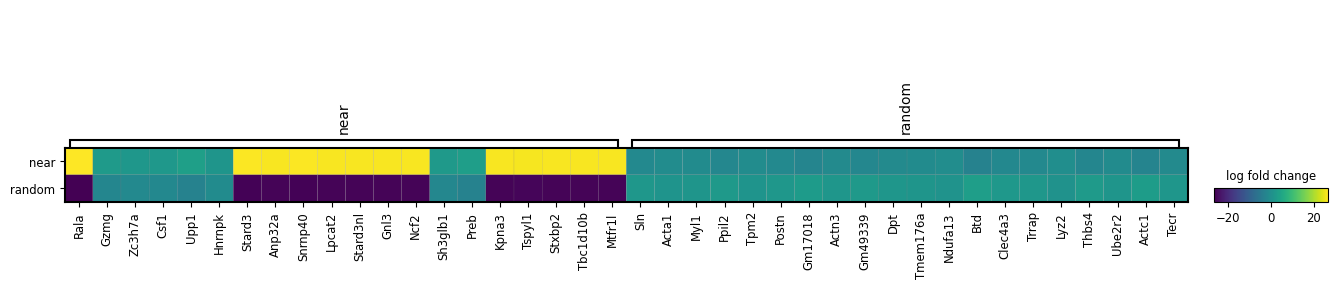

In [282]:
sc.tl.rank_genes_groups(fdata_filt_bin20, groupby="cluster", method="t-test_overestim_var")
plt.figure(figsize=(20, 20))
sc.pl.rank_genes_groups_matrixplot(fdata_filt_bin20, n_genes=20, values_to_plot="logfoldchanges")

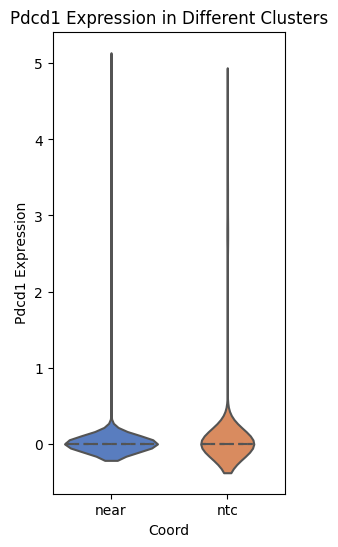

In [283]:
a = fdata_filt_bin20[fdata_filt_bin20.obs["cluster"] == "near", "Pdcd1"].X.toarray().flatten()
b = fdata_filt_bin20[fdata_filt_bin20.obs["cluster"] == "random", "Pdcd1"].X.toarray().flatten()

plot_df = pd.DataFrame({
    "Pdcd1": a.tolist() + b.tolist(),
    "coord": ["near"] * len(a) + ["ntc"] * len(b)
})

plt.figure(figsize=(3, 6))
sns.violinplot(x='coord', y='Pdcd1', data=plot_df, inner='quartile', palette='muted')
plt.xlabel('Coord')
plt.ylabel('Pdcd1 Expression')
plt.title('Pdcd1 Expression in Different Clusters')
plt.show()

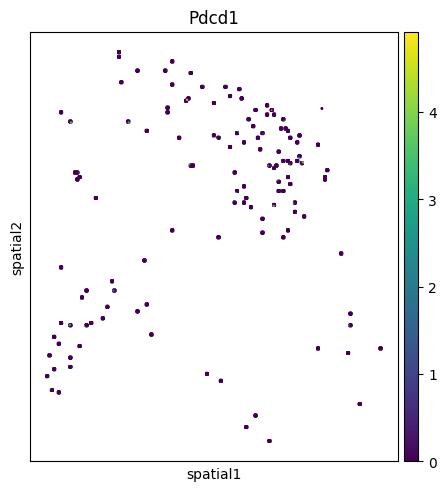

In [284]:
sq.pl.spatial_scatter(fdata_filt_bin20, color="Pdcd1", size=1, shape=None, library_id="spatial")

# Local Moras's I

In [184]:
interest_bin = extract_bin20(cdata_bin20, cdata_1[near_mask])
interest_bin

AnnData object with n_obs × n_vars = 20265 × 34
    obs: 'spatial_cov'
    obsm: 'spatial'

In [185]:
cdata_1[near_mask, "sgGata3"].X.sum()

array(7334)

In [186]:
interest_bin[:, "sgGata3"].X.sum()

array(7334)

In [24]:
interest_bin.obs["annotations"].value_counts()

annotations
Macrophages    1221
Malignant       966
Fibroblast      214
Unknown T       120
B               101
effector T       79
MuscleCell       68
DC               60
Others           31
memory T         27
NK               24
exhausted T      23
Endothelial      23
stem-like T      11
Name: count, dtype: int64

In [154]:
interest_bin = extract_bin20(fdata_bin20, fdata_1[random_mask])
interest_bin

NameError: name 'random_mask' is not defined

In [289]:
interest_bin.obs["annotations"].value_counts()

annotations
Macrophages    264
Malignant      188
Fibroblast      68
MuscleCell      20
Unknown T       19
effector T      17
DC              16
B               13
NK               6
exhausted T      5
memory T         5
stem-like T      2
Endothelial      2
Others           2
Epithelial       1
Name: count, dtype: int64

In [3]:
I = []
for i in tqdm(range(np.sum(mask))):
    interest_bin = extract_bin20(cdata_bin20, find_near(cdata_1[mask][i], cdata_1, border=1))
    p_data = interest_bin[:, "sgGata3"].copy()
    sq.gr.spatial_neighbors(p_data, n_neighs=1)
    I.append(sq.gr.spatial_autocorr(p_data, copy=True)["I"][0])

NameError: name 'mask' is not defined

In [15]:
T_marker = {
    "naive T": ["Ccr7", "Tcf7", "Lef1", "Sell", "Klf2"],
    "memory T": ["Il7r", "Cd27", "Timp1"],
    "Tcm": ["Ccr7", "Sell"],
    "Tem": ["Eomes", "Gzmk"],
    "Trm": ["Cd69", "Itgae", "Xcl1", "Zfp683", "Klf2", "S1pr1"],
    "Temra": ["Tbx21", "Gzmb", "Nkg7"],
    "effector T": ["Gzmk", "Gzma", "Gzmb", "Prf1", "Nkg7"],
    "exhausted T": ["Havcr2", "Lag3", "Entpd1", "Tigit", "Ctla4", "Layn"],
    "stem-like T": ["Tcf7", "Foxo1"]
}

In [16]:
for marker in tqdm(T_marker):
    sc.tl.score_genes(fdata_bin20, T_marker[marker], score_name=f"{marker}_score")

In [18]:
TI = []
for i in tqdm(range(np.sum(mask))):
    interest_bin = extract_bin20(fdata_bin20, find_near(fdata_1[mask][i], fdata_1, border=1))
    p_data = interest_bin.copy()
    
    new_data = ad.AnnData(np.array(p_data.obs["exhausted T_score"].tolist()).reshape(-1, 1), obs=pd.DataFrame(index=p_data.obs_names), var=pd.DataFrame(index=["score"]))
    new_data.obsm["spatial"] = p_data.obsm["spatial"]
    sq.gr.spatial_neighbors(new_data, n_neighs=1)
    TI.append(sq.gr.spatial_autocorr(new_data, copy=True, genes=["score"])["I"][0])
    del(new_data)

 24%|██▍       | 29/119 [01:56<06:19,  4.21s/it]

: 

: 

: 

In [232]:
sq.gr.spatial_autocorr(new_data, copy=True, genes=["score"])["I"][0]

-0.037050111719328975

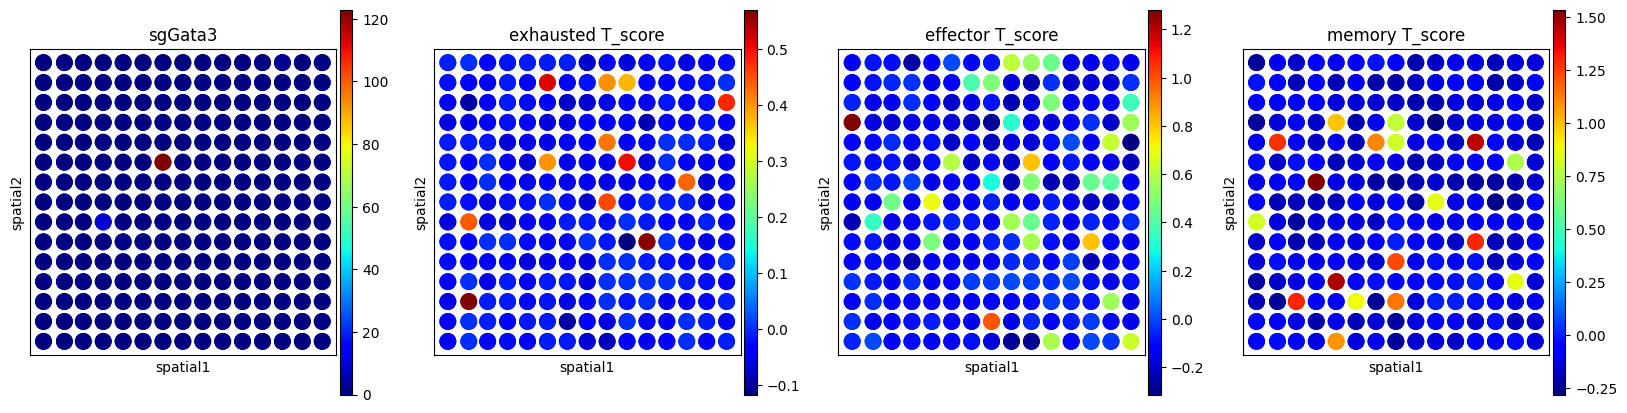

In [171]:
i = 89
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
sq.pl.spatial_scatter(extract_bin20(cdata_bin20, find_near(cdata_1[mask][i], cdata_1, border=1)), color="sgGata3", shape=None, size=500, library_id="spatial", ax=ax[0], cmap='jet')
sq.pl.spatial_scatter(extract_bin20(fdata_bin20, find_near(fdata_1[mask][i], fdata_1, border=1)), color="exhausted T_score", shape=None, size=500, library_id="spatial", ax=ax[1], cmap='jet')
sq.pl.spatial_scatter(extract_bin20(fdata_bin20, find_near(fdata_1[mask][i], fdata_1, border=1)), color="effector T_score", shape=None, size=500, library_id="spatial", ax=ax[2], cmap='jet')
sq.pl.spatial_scatter(extract_bin20(fdata_bin20, find_near(fdata_1[mask][i], fdata_1, border=1)), color="memory T_score", shape=None, size=500, library_id="spatial", ax=ax[3], cmap='jet')
plt.show()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


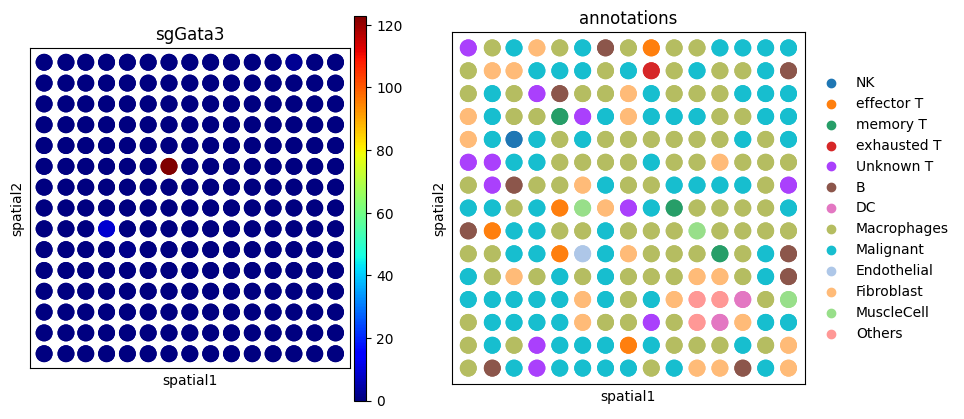

In [173]:
i = 89
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sq.pl.spatial_scatter(extract_bin20(cdata_bin20, find_near(cdata_1[mask][i], cdata_1, border=1)), color="sgGata3", shape=None, size=500, library_id="spatial", ax=ax[0], cmap='jet')
sq.pl.spatial_scatter(extract_bin20(fdata_bin20, find_near(fdata_1[mask][i], fdata_1, border=1)), color="annotations", shape=None, size=500, library_id="spatial", ax=ax[1], cmap='jet')
plt.show()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


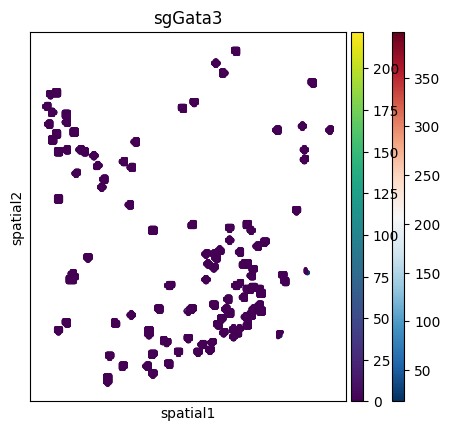

In [340]:
fig, ax = plt.subplots(1, 1)
sq.pl.spatial_scatter(cdata_1[mask], color="sgGata3", cmap="RdBu_r", shape=None, size=30, library_id="spatial", ax=ax)
sq.pl.spatial_scatter(cdata_filt, color="sgGata3", shape=None, size=10, library_id="spatial", ax=ax)

In [128]:
fdata_bin20

AnnData object with n_obs × n_vars = 568003 × 27798
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt1', 'pct_counts_mt1', 'total_counts_mt2', 'pct_counts_mt2', 'total_counts_rb', 'pct_counts_rb', 'annotations'
    var: 'mt1', 'mt2', 'rb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p', 'rank_genes_groups'
    obsm: 'spatial'
    layers: 'counts'

In [222]:
p_df = pd.DataFrame([I, fdata_1[mask, "Pdcd1"].X.toarray().flatten()])

In [223]:
p_df.iloc[0, :]

0     -0.022578
1     -0.007488
2     -0.003144
3     -0.007545
4     -0.010792
         ...   
114   -0.021587
115    0.000959
116   -0.010830
117   -0.008627
118   -0.012961
Name: 0, Length: 119, dtype: float64

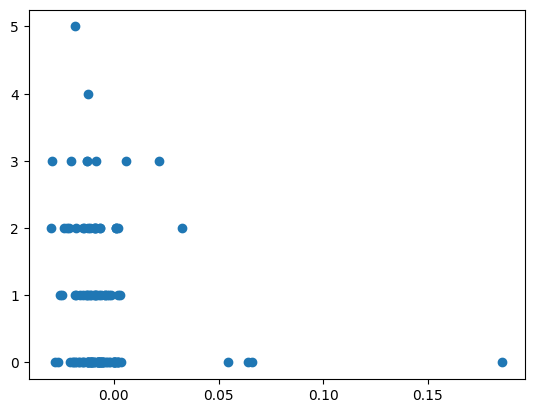

In [224]:
plt.scatter(x=p_df.iloc[0], y=p_df.iloc[1])
plt.show()

In [225]:
p_df.dropna(inplace=True)

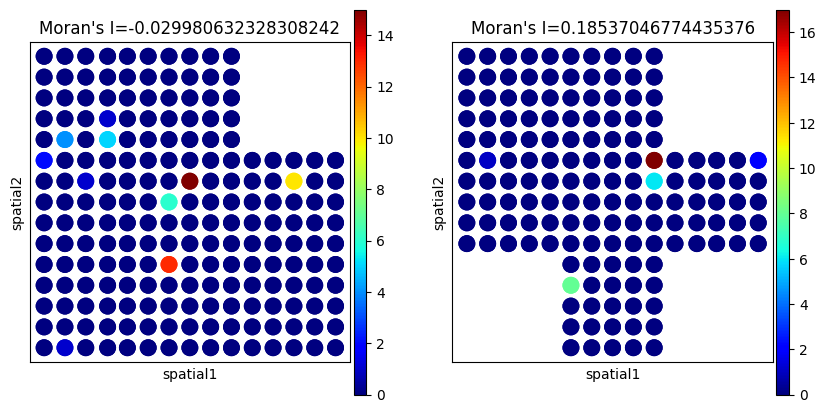

In [230]:
i = np.argmin(p_df.iloc[0])
j = np.argmax(p_df.iloc[0])
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
near_mask = cdata_1.obsp["spatial_distances"][np.where(mask)[0][i]].toarray().sum(axis=0) > 0
near_mask = near_mask.flatten()
near_mask[np.where(mask)[0][i]] = True
sq.pl.spatial_scatter(extract_bin20(cdata_bin20, cdata_1[near_mask])[:, "sgGata3"], color="sgGata3", shape=None, size=500, library_id="spatial", ax=ax[0], cmap='jet')
ax[0].set_title("Moran's I=" + str(p_df.iloc[0, i]))
near_mask = cdata_1.obsp["spatial_distances"][np.where(mask)[0][j]].toarray().sum(axis=0) > 0
near_mask = near_mask.flatten()
near_mask[np.where(mask)[0][j]] = True
sq.pl.spatial_scatter(extract_bin20(cdata_bin20, cdata_1[near_mask])[:, "sgGata3"], color="sgGata3", shape=None, size=500, library_id="spatial", ax=ax[1], cmap='jet')
ax[1].set_title("Moran's I=" + str(p_df.iloc[0, j]))
plt.show()

/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(
/home/wpy/miniconda3/envs/scanpy/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:955: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


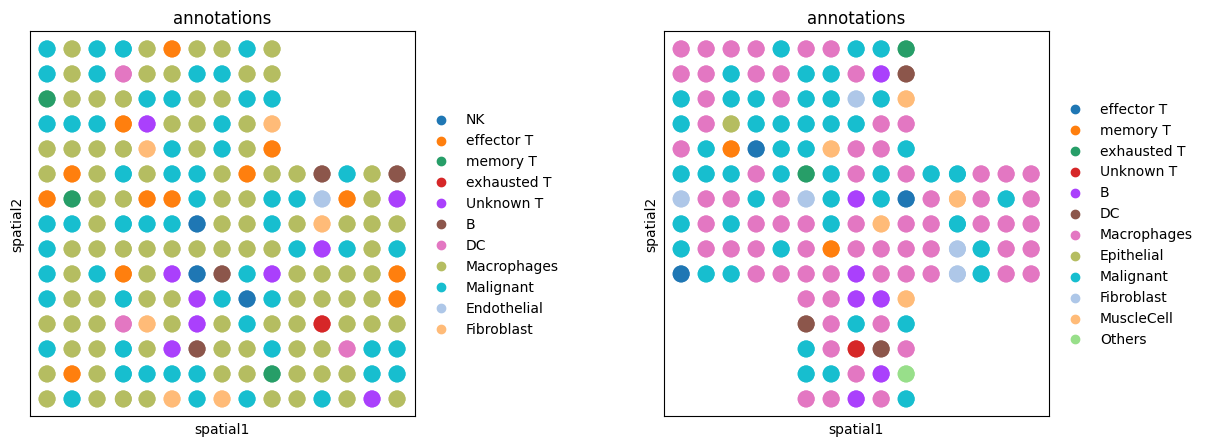

In [252]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
near_mask = cdata_1.obsp["spatial_distances"][np.where(mask)[0][i]].toarray().sum(axis=0) > 0
near_mask = near_mask.flatten()
near_mask[np.where(mask)[0][i]] = True
fdata_filt = extract_bin20(fdata_bin20, fdata_1[near_mask])

sq.pl.spatial_scatter(fdata_filt, color="annotations", shape=None, size=500, library_id="spatial", cmap='jet', ax=ax[0])

near_mask = cdata_1.obsp["spatial_distances"][np.where(mask)[0][j]].toarray().sum(axis=0) > 0
near_mask = near_mask.flatten()
near_mask[np.where(mask)[0][j]] = True
fdata_filt = extract_bin20(fdata_bin20, fdata_1[near_mask])

sq.pl.spatial_scatter(fdata_filt, color="annotations", shape=None, size=500, library_id="spatial", cmap='jet', ax=ax[1])
plt.show()

In [33]:
np.where(mask)[0][67]

9589

In [56]:
cdata_1[np.where(mask)[0][67]].obsm["spatial"] // 100 * 100

array([[10400,  6700]])

In [84]:
cdata_1[[array[0] // 100 * 100 == 10400 and array[1] // 100 * 100 == 6700 for array in cdata_1.obsm["spatial"]]].obsm["spatial"]

ArrayView([[10449,  6749]])

In [60]:
sq.gr.spatial_neighbors(cdata_1)

In [72]:
cdata_1.obsp["spatial_distances"][67].toarray()[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [85]:
for n in np.where(cdata_1.obsp["spatial_distances"][67].toarray()[0] > 0):
    print(cdata_1.obsm["spatial"][n])

[[ 1950 11349]
 [ 2049 11349]
 [ 1849 11448]
 [ 1950 11549]
 [ 2049 11448]]


In [79]:
cdata_1[[array[0] == 10449 and array[1] == 6749 for array in cdata_1.obsm["spatial"]]]

View of AnnData object with n_obs × n_vars = 1 × 34
    uns: 'spatial_neighbors'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [51]:
cdata_1[(cdata_1.obsm["spatial"] == 10449).sum(axis=1) == 1 for ]

AttributeError: 'numpy.ndarray' object has no attribute 'map'

In [82]:
cdata_1.obsm["spatial"][(cdata_1.obsm["spatial"] == 10449).sum(axis=1)]

array([[5749,  449],
       [5749,  449],
       [5749,  449],
       ...,
       [5749,  449],
       [5749,  449],
       [5749,  449]])

In [263]:
expression = np.zeros((np.sum(mask), len(fdata_bin20.var_names)))
for i in tqdm(range(np.sum(mask))):
    near_mask = cdata_1.obsp["spatial_distances"][np.where(mask)[0][j]].toarray().sum(axis=0) > 0
    near_mask = near_mask.flatten()
    near_mask[np.where(mask)[0][j]] = True
    fdata_filt = extract_bin20(fdata_bin20, fdata_1[near_mask])

    expression[i, :] = fdata_filt.X.toarray().mean(axis=0)

  0%|          | 0/68 [00:00<?, ?it/s]


IndexError: row index (27791) out of range

In [264]:
fdata_filt.var_names

Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610009O20Rik',
       '0610010F05Rik', '0610010K14Rik', '0610012D04Rik', '0610012G03Rik',
       '0610025J13Rik', '0610030E20Rik',
       ...
       'sgWipf1_1_gene', 'sgWipf1_2_gene', 'sgZc3h12a_1_gene',
       'sgZc3h12a_2_gene', 'sgZhx2_1_gene', 'sgZhx2_2_gene',
       'sgZscan12_1_gene', 'sgZscan12_2_gene', 'sgnon-targeting_1_gene',
       'sgnon-targeting_2_gene'],
      dtype='object', length=27798)

In [260]:
fdata.var_names

Index(['0610005C13Rik', '0610006L08Rik', '0610009B22Rik', '0610009O20Rik',
       '0610010F05Rik', '0610010K14Rik', '0610012D04Rik', '0610012G03Rik',
       '0610025J13Rik', '0610030E20Rik',
       ...
       'mt-Co2', 'mt-Co3', 'mt-Cytb', 'mt-Nd1', 'mt-Nd2', 'mt-Nd3', 'mt-Nd4',
       'mt-Nd4l', 'mt-Nd5', 'mt-Nd6'],
      dtype='object', length=27889)